In [1]:
!pip install sumy rouge-score

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.3/97.3 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 59.9 MB/s eta 0:00:0000:0100:01
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=5ac69cf1d9406c0c82b0bc24ffae7f3b0a7f28c60c9ad9b87e3fc8c946930561
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
  Created wheel for breadability: filename=breadability-0.1.20-py2.py3-none-any.whl size=21692 sha256=e65f13a20e04d96b2525a576e4a93b9f7622c900bdb01a34728f2894fc72e5fd
  Stored in directory: /root/.cache/pip/wheels/64/22/90/b84fcc30e16598db20a0d41340616dbf9b1e82bbcc627b0b33
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=7f06dd91dabdb894b05fe69da332c221aaad8757990c404d03507f4a68301c43
  Stored in direc

Applying summarizations on the top 2000 articles...


100%|██████████| 2000/2000 [00:46<00:00, 43.47it/s]


Applying summarizations on the top 2000 articles...


100%|██████████| 2000/2000 [00:39<00:00, 50.65it/s]



Evaluating summaries using Highlights as reference...

Training Data ROUGE Scores (Highlights as Reference):
{'lead3_summary': {'ROUGE-1': 0.2728361243033702, 'ROUGE-2': 0.10772545100121268, 'ROUGE-L': 0.1750027994366227}, 'lexrank_summary': {'ROUGE-1': 0.3122774715378724, 'ROUGE-2': 0.09934005204427432, 'ROUGE-L': 0.1902392678237283}, 'textrank_summary': {'ROUGE-1': 0.27885150334224945, 'ROUGE-2': 0.08927823726712523, 'ROUGE-L': 0.1739514625112167}, 'lsa_summary': {'ROUGE-1': 0.28622108207973135, 'ROUGE-2': 0.07995122736962246, 'ROUGE-L': 0.17423354950892095}}


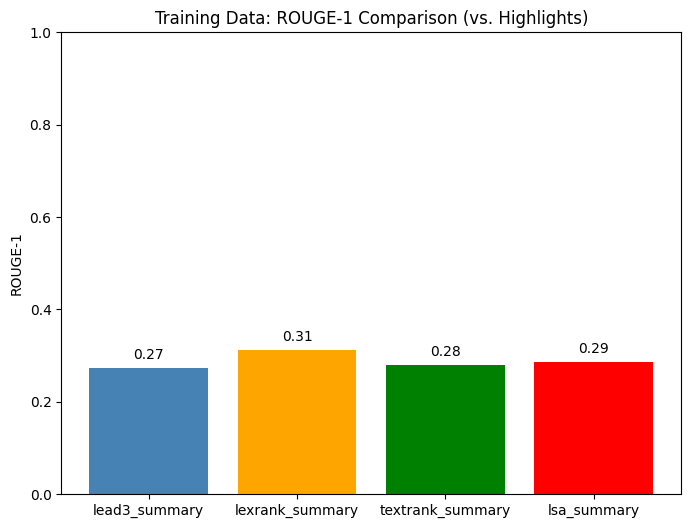

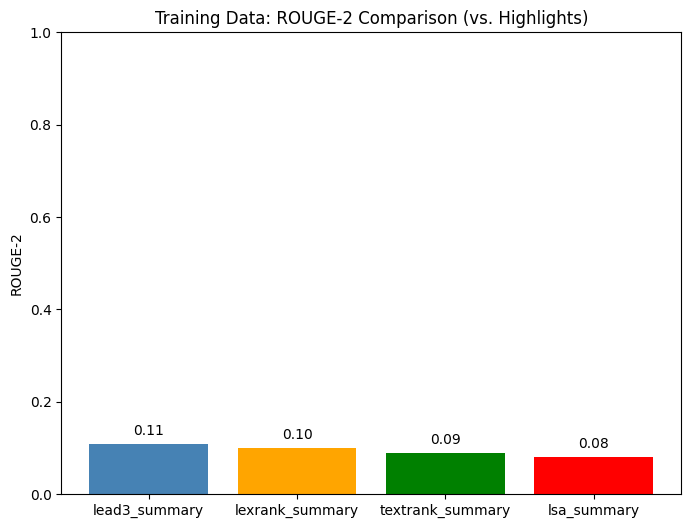

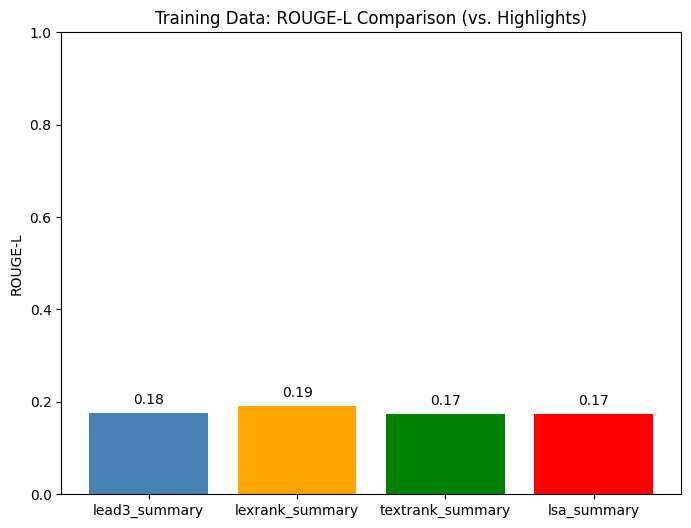

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer

# Import summarizers from Sumy
from sumy.summarizers.lex_rank import LexRankSummarizer
from sumy.summarizers.text_rank import TextRankSummarizer
from sumy.summarizers.lsa import LsaSummarizer

from tqdm import tqdm  # For progress visualization
tqdm.pandas()

# For ROUGE evaluation
from rouge_score import rouge_scorer

# Initialize the ROUGE scorer (using stemmer)
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

#########################
# Summarization Methods #
#########################

def lead3_summary(text, sentence_count=3):
    """
    Generates a Lead-3 summary by taking the first three sentences.
    This uses a simple period-based splitting.
    """
    try:
        # Simple sentence splitting using period+space.
        sentences = text.split('. ')
        if len(sentences) >= sentence_count:
            summary = ". ".join(sentences[:sentence_count])
            if not summary.endswith('.'):
                summary += "."
            return summary
        else:
            return text
    except Exception as e:
        print(f"Error processing Lead-3: {e}")
        return ""

def lexrank_summary(text, sentence_count=3):
    try:
        parser = PlaintextParser.from_string(text, Tokenizer("english"))
        summarizer = LexRankSummarizer()
        summary_sentences = summarizer(parser.document, sentence_count)
        return " ".join(str(sentence) for sentence in summary_sentences)
    except Exception as e:
        print(f"Error processing LexRank: {e}")
        return ""

def textrank_summary(text, sentence_count=3):
    try:
        parser = PlaintextParser.from_string(text, Tokenizer("english"))
        summarizer = TextRankSummarizer()
        summary_sentences = summarizer(parser.document, sentence_count)
        return " ".join(str(sentence) for sentence in summary_sentences)
    except Exception as e:
        print(f"Error processing TextRank: {e}")
        return ""

def lsa_summary(text, sentence_count=3):
    try:
        parser = PlaintextParser.from_string(text, Tokenizer("english"))
        summarizer = LsaSummarizer()
        summary_sentences = summarizer(parser.document, sentence_count)
        return " ".join(str(sentence) for sentence in summary_sentences)
    except Exception as e:
        print(f"Error processing LSA: {e}")
        return ""

#########################################
# Apply Summarizations to the DataFrame  #
#########################################

def apply_summarizations(df, text_column="article", sentence_count=3, top_n=10):
    """
    Applies Lead-3, LexRank, TextRank, and LSA summarizations to the top N articles in the DataFrame.
    """
    df_subset = df.head(top_n).copy()
    print(f"Applying summarizations on the top {len(df_subset)} articles...")
    
    df_subset["lead3_summary"] = df_subset[text_column].progress_apply(
        lambda x: lead3_summary(x, sentence_count) if isinstance(x, str) else ""
    )
    df_subset["lexrank_summary"] = df_subset[text_column].progress_apply(
        lambda x: lexrank_summary(x, sentence_count) if isinstance(x, str) else ""
    )
    df_subset["textrank_summary"] = df_subset[text_column].progress_apply(
        lambda x: textrank_summary(x, sentence_count) if isinstance(x, str) else ""
    )
    df_subset["lsa_summary"] = df_subset[text_column].progress_apply(
        lambda x: lsa_summary(x, sentence_count) if isinstance(x, str) else ""
    )
    
    return df_subset

#######################################
# ROUGE Evaluation Functions          #
#######################################

def compute_rouge_scores(reference, candidate):
    """
    Computes ROUGE-1, ROUGE-2, and ROUGE-L scores for a pair of summaries.
    """
    return scorer.score(reference, candidate)

def evaluate_summaries(df, reference_column="highlights"):
    """
    Computes average ROUGE scores for each summarization method compared to the given reference column.
    Here, we compare all four methods (lead3, lexrank, textrank, lsa) to the human-written "highlights".
    Returns a dictionary with the results.
    """
    # Include all methods in the evaluation.
    methods = ["lead3_summary", "lexrank_summary", "textrank_summary", "lsa_summary"]
    results = {}
    
    for method in methods:
        rouge1, rouge2, rougeL = 0, 0, 0
        count = 0
        for idx, row in df.iterrows():
            reference = row[reference_column]
            candidate = row[method]
            if reference and candidate:
                scores = compute_rouge_scores(reference, candidate)
                rouge1 += scores['rouge1'].fmeasure
                rouge2 += scores['rouge2'].fmeasure
                rougeL += scores['rougeL'].fmeasure
                count += 1
        if count > 0:
            results[method] = {
                "ROUGE-1": rouge1 / count,
                "ROUGE-2": rouge2 / count,
                "ROUGE-L": rougeL / count,
            }
        else:
            results[method] = {"ROUGE-1": 0, "ROUGE-2": 0, "ROUGE-L": 0}
    
    return results

#########################################
# Plotting Functions for Visualization  #
#########################################

def plot_results(results, title_prefix=""):
    """
    Plots bar graphs for each ROUGE metric comparing the summarization methods against the "highlights" reference.
    """
    metrics = ["ROUGE-1", "ROUGE-2", "ROUGE-L"]
    methods = list(results.keys())  # This should include all methods (lead3, lexrank, textrank, lsa)
    
    for metric in metrics:
        scores = [results[m][metric] for m in methods]
        
        plt.figure(figsize=(8, 6))
        plt.bar(methods, scores, color=['steelblue', 'orange', 'green', 'red'])
        plt.ylabel(metric)
        plt.ylim(0, 1)  # ROUGE scores range between 0 and 1
        plt.title(f"{title_prefix}{metric} Comparison (vs. Highlights)")
        for i, score in enumerate(scores):
            plt.text(i, score + 0.02, f"{score:.2f}", ha='center')
        plt.show()

#########################
# Main Execution Block  #
#########################

# Load datasets (for context, we load top 10,000 rows)
train_df = pd.read_csv('/kaggle/input/newspaper-text-summarization-cnn-dailymail/cnn_dailymail/train.csv', nrows=10000)
test_df = pd.read_csv('/kaggle/input/newspaper-text-summarization-cnn-dailymail/cnn_dailymail/test.csv', nrows=10000)

# Apply summarizations on a subset (e.g., top 100 rows)
train_df_subset = apply_summarizations(train_df, text_column="article", sentence_count=3, top_n=2000)
test_df_subset = apply_summarizations(test_df, text_column="article", sentence_count=3, top_n=2000)

# --- Evaluation: Using 'highlights' as Reference ---
print("\nEvaluating summaries using Highlights as reference...")
results_train = evaluate_summaries(train_df_subset, reference_column="highlights")
results_test = evaluate_summaries(test_df_subset, reference_column="highlights")

# Display the results (for training data)
print("\nTraining Data ROUGE Scores (Highlights as Reference):")
print(results_train)

# Plot the results for training data
plot_results(results_train, title_prefix="Training Data: ")
